In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv
/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


## Importing libraries

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
df_org = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

In [4]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB
None


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
print(df_org.info())
df_org.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [6]:
df_org.drop(columns=["RowNumber"], inplace=True)
df_train.drop(columns=["id"], inplace=True)

#### Filling the Null value present in "HasCrCard"

In [7]:
print("Peope who exited and DONT own a credit card",(df_org[(df_org["Exited"]==0) & (df_org["HasCrCard"]==0)].shape[0] / df_org[df_org["Exited"]==0].shape[0]))
print("Peope who exited and OWN a credit card",(df_org[(df_org["Exited"]==0) & (df_org["HasCrCard"]==1)].shape[0] / df_org[df_org["Exited"]==0].shape[0]))

Peope who exited and DONT own a credit card 0.292817679558011
Peope who exited and OWN a credit card 0.7070567553992968


In [8]:
df_org["HasCrCard"].fillna(1.0)

0        1.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
9997     0.0
9998     1.0
9999     1.0
10000    1.0
10001    1.0
Name: HasCrCard, Length: 10002, dtype: float64

In [9]:
df_org.dropna(inplace=True)
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 10001
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       9998 non-null   int64  
 1   Surname          9998 non-null   object 
 2   CreditScore      9998 non-null   int64  
 3   Geography        9998 non-null   object 
 4   Gender           9998 non-null   object 
 5   Age              9998 non-null   float64
 6   Tenure           9998 non-null   int64  
 7   Balance          9998 non-null   float64
 8   NumOfProducts    9998 non-null   int64  
 9   HasCrCard        9998 non-null   float64
 10  IsActiveMember   9998 non-null   float64
 11  EstimatedSalary  9998 non-null   float64
 12  Exited           9998 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 1.1+ MB


In [10]:
#clean original data
#concatenate the datasets
df = pd.concat([df_train, df_org], ignore_index=False)
df.shape

(175032, 13)

In [11]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [12]:
df.select_dtypes("object").nunique()

Surname      2932
Geography       3
Gender          2
dtype: int64

### EDA on gender

In [13]:
females = (df[df["Gender"] == "Female"].shape[0]/df.shape[0])*100
print("Percentage of females : ", females)
males = (df[df["Gender"] == "Male"].shape[0]/df.shape[0])*100
print("Percentage of males : ", males)

Percentage of females :  43.66458704693999
Percentage of males :  56.335412953060015


In [14]:
print(df[df["Gender"]=="Female"].shape[0])
print(df[df["Gender"]=="Male"].shape[0])

76427
98605


In [15]:
print((df[(df["Gender"]=="Female") & (df["Exited"]==1)].shape[0] / (df[df["Gender"]=="Female"].shape[0]))*100)
print((df[(df["Gender"]=="Male") & (df["Exited"]==1)].shape[0] / (df[df["Gender"]=="Male"].shape[0]))*100)

27.79645936645426
15.937325693423254


### EDA on geography

In [16]:
df["Geography"].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [17]:
# Total people in france and how many exited
france = df["Geography"] == "France"
exit = df["Exited"] == 1

France_people = df[france].shape[0]
France_people_exited = df[france & exit].shape[0]

print("France_people: ",France_people)
print("France_people exited: ",France_people_exited)
print("Percentage of France_people exited: ", (France_people_exited/France_people)*100)

France_people:  99227
France_people exited:  16382
Percentage of France_people exited:  16.509619357634513


In [18]:
# Total people in Spain and how many exited
spain = df["Geography"] == "Spain"
exit = df["Exited"] == 1

spain_people = df[spain].shape[0]
spain_people_exited = df[spain & exit].shape[0]

print("spain_people: ",spain_people)
print("spain_people exited: ",spain_people_exited)
print("Percentage of spain_people exited: ", (spain_people_exited/spain_people)*100)

spain_people:  38689
spain_people exited:  6648
Percentage of spain_people exited:  17.183178681278914


In [19]:
# Total people in Spain and how many exited
Germany = df["Geography"] == "Germany"
exit = df["Exited"] == 1

Germany_people = df[Germany].shape[0]
Germany_people_exited = df[Germany & exit].shape[0]

print("Germany_people: ",Germany_people)
print("Germany_people exited: ",Germany_people_exited)
print("Percentage of Germany_people exited: ", (Germany_people_exited/Germany_people)*100)

Germany_people:  37116
Germany_people exited:  13929
Percentage of Germany_people exited:  37.528289686388625


### Not a very significant feature so we will drop it as well

In [20]:
## features to drop
features_to_drop = ["Surname", "CustomerId", "Gender", "Geography"]

In [21]:
df.drop(columns = features_to_drop, inplace=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0


#### EDA on AGE

In [22]:
df["Age"].describe()

count    175032.000000
mean         38.171265
std           8.969537
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

In [23]:
young = df["Age"].between(18, 32)
exit = df["Exited"] == 1

youngsters = df[young].shape[0]
youngsters_exited = df[young & exit].shape[0]

print("Youngsters: ",youngsters)
print("Youngsters exited: ",youngsters_exited)
print("Percentage of youngsters exited: ", (youngsters_exited/youngsters)*100)

Youngsters:  46463
Youngsters exited:  3783
Percentage of youngsters exited:  8.1419624217119


In [24]:
adult = df["Age"].between(32, 47)
exit = df["Exited"] == 1

adults = df[adult].shape[0]
adults_exited = df[adult & exit].shape[0]

print("adults: ",adults)
print("adults exited: ",adults_exited)
print("Percentage of adults exited: ", (adults_exited/adults)*100)

adults:  113403
adults exited:  21261
Percentage of adults exited:  18.7481812650459


In [25]:
Older = df["Age"].between(47, 100)
exit = df["Exited"] == 1

Olders = df[Older].shape[0]
Olders_exited = df[Older & exit].shape[0]

print("Olders: ",Olders)
print("Olders exited: ",Olders_exited)
print("Percentage of Olders exited: ", (Olders_exited/Olders)*100)

Olders:  26204
Olders exited:  13993
Percentage of Olders exited:  53.40024423752099


Age seems to be an interesting feature as the younger people hardly exited the bank, so we can make 3 different categories in a new columns and drop the age feature, that way our model may learn the pattern better

In [26]:
#replace age with categories, young=0, adult=1, old = 2
age_list = []
for i in range (df.shape[0]):
    if df["Age"].iloc[i]>=18 and df["Age"].iloc[i]<32:
        age_list.append(0)
    elif df["Age"].iloc[i]>=32 and df["Age"].iloc[i]<47:
        age_list.append(1)
    else:
        age_list.append(2)
        
age_list[:5]

[1, 1, 1, 1, 1]

In [27]:
# df["Age"] = age_list
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Checking correlation

<Axes: >

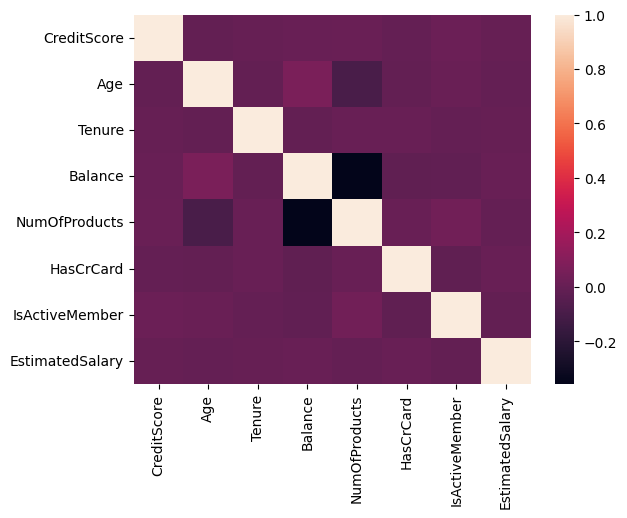

In [28]:
#checking heatmap
corr = df.drop(columns=["Exited"]).corr()
sns.heatmap(corr)

## Split

In [29]:
target = "Exited"
y = df[target]
X = df.drop(columns = [target])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140025, 8)
(35007, 8)
(140025,)
(35007,)


In [31]:
#Make Loistic Regression pipeline
model_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

## Logistic model

In [32]:
model_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [33]:
y_pred_lr = model_lr.predict_proba(X_test)[:,1]
roc = roc_auc_score(y_test, y_pred_lr)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_lr)
roc

0.7899681448965132

## Plot the curve

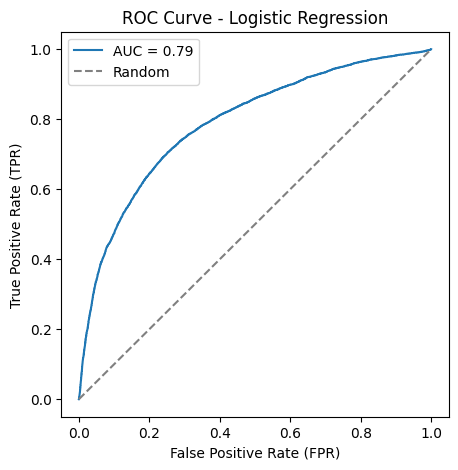

In [34]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [35]:
# Random Forest Model
model_rf = make_pipeline(RandomForestClassifier(n_estimators=500,random_state = 42))
model_rf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500, random_state=42))])

In [36]:
y_pred_rf = model_rf.predict_proba(X_test)[:,1]
roc_rf = roc_auc_score(y_test, y_pred_rf)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_rf)
roc_rf

0.8553918012524159

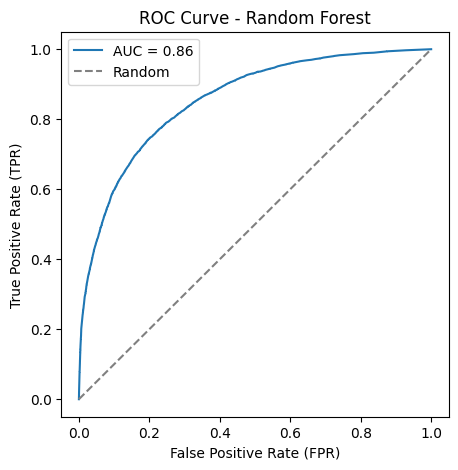

In [37]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

### LGBM

In [38]:
model_lgbm = LGBMClassifier(n_estimators = 150, random_state=42)
model_lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=150, random_state=42)

In [39]:
y_pred_lgbm = model_lgbm.predict_proba(X_test)[:,1]
roc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_lgbm)
roc_lgbm

0.8735885828906551

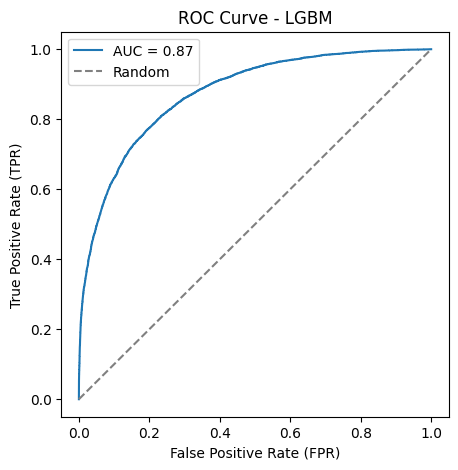

In [40]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_lgbm:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - LGBM')
plt.legend()
plt.show()

### Mean prediction

In [41]:
y_pred_mean = (y_pred_lr + y_pred_rf + y_pred_lgbm)/3
roc_mean = roc_auc_score(y_test, y_pred_mean)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_mean)
roc_mean

0.8658900626803885

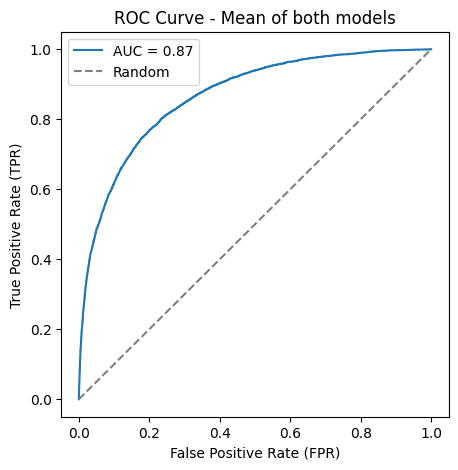

In [42]:
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_mean:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Mean of both models')
plt.legend()
plt.show()

In [43]:
#weighted mean
y_pred_w_mean = (0.9*y_pred_rf + 1.2*y_pred_lgbm)/2
roc_w_mean = roc_auc_score(y_test, y_pred_w_mean)
fpr,tpr,thresholds = roc_curve(y_test, y_pred_w_mean)
roc_w_mean

0.8700255563195527

## Working on test data

In [44]:
features_dropped = ["id", "CustomerId", "Gender", "Geography", "Surname"]

In [45]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [46]:
df_id = df_test["id"]
df_test.drop(columns = features_dropped, inplace=True)
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      110023 non-null  int64  
 1   Age              110023 non-null  float64
 2   Tenure           110023 non-null  int64  
 3   Balance          110023 non-null  float64
 4   NumOfProducts    110023 non-null  int64  
 5   HasCrCard        110023 non-null  float64
 6   IsActiveMember   110023 non-null  float64
 7   EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 6.7 MB
None


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,38.0,10,121263.62,1,1.0,0.0,139431.00


In [47]:
#Making Age Categories
age_list = []
for i in range (df_test.shape[0]):
    if df_test["Age"].iloc[i]>=18 and df_test["Age"].iloc[i]<32:
        age_list.append(0)
    elif df_test["Age"].iloc[i]>=32 and df_test["Age"].iloc[i]<47:
        age_list.append(1)
    else:
        age_list.append(2)
        
print(age_list[:5])
# df_test["Age"] = age_list
df_test.head()

[0, 1, 1, 1, 1]


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,38.0,10,121263.62,1,1.0,0.0,139431.00


In [48]:
# predictions_lr = model_lr.predict_proba(df_test)[:,1]
# predictions_rf = model_rf.predict_proba(df_test)[:,1]
# predictions = (predictions_lr + predictions_rf)/2
predictions = model_lgbm.predict_proba(df_test)[:,1]

In [49]:
len(predictions)

110023

In [50]:
submission = pd.concat([df_id, pd.DataFrame(predictions)], axis=1,ignore_index=True)
submission.head()

,0,1
0,165034,0.017587
1,165035,0.784287
2,165036,0.017205
3,165037,0.301271
4,165038,0.277746


In [51]:
submission.columns = ["id", "Exited"]

In [52]:
submission.to_csv("submission.csv", index=False)